In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
import matplotlib
import datetime
from scipy.stats import norm
import imageio
from matplotlib.gridspec import GridSpec

from lib.analysis.laminar_dist import Line

# based on reference http://www.georgemather.com/Model.html#Refs

In [2]:
# an object moving in circles?
stim_type = ['circular_point',  # 0
             'single_pulse',    # 1
             'translating_bar', # 2
             'circular_edge',   # 3
             'double_pulse', ][4]   # 4

In [3]:
# intralaminar PV velocities over barrels of size 100-300 um
barrel_latency_PV = 200 / 57  # ms
barrel_latency_PV_se = 100 / 41
# Katherine S Scheuer, John M Judge, Xinyu Zhao, Meyer B Jackson, Velocity of conduction between columns and layers in barrel cortex reported by parvalbumin interneurons, Cerebral Cortex 33:17, 1 Sept 2023, p 9917–9926
print(barrel_latency_PV, barrel_latency_PV_se)

3.508771929824561 2.4390243902439024


In [4]:
barrel_latency_PV_excitatory_L4 = 1.028032
barrel_latency_PV_excitatory_L4_se = 1.0011922707332492

In [5]:
# Barrel cortex motion
# from http://www.georgemather.com/Model.html#Refs

# Define the space axis of the filters
nx_row = 8
ny_arc = 5
max_x = 0.2  # Half-width of filter (deg)
max_y = 0.2
dx = (max_x * 2) / nx_row  # Spatial sampling interval of filter (deg)
dy = (max_y * 2) / ny_arc

# A row vector holding spatial sampling intervals
x_filt = np.linspace(-max_x, max_x, nx_row)
y_filt = np.linspace(-max_y, max_y, ny_arc)

# Spatial filter parameters
sx = 0.05 # standard deviation of Gaussian, in deg.
sfx = 0.11 # spatial frequency of carrier, in cpd
sy = 0.05 # standard deviation of Gaussian, in deg.
sfy = 0.11 # spatial frequency of carrier, in cpd

# Spatial filter response
gauss_x = np.exp(-x_filt ** 2 / sx ** 2)  # Gaussian envelope
even_x = np.cos(2 * np.pi * sfx * x_filt) * gauss_x  # Even Gabor
odd_x = np.sin(2 * np.pi * sfx * x_filt) * gauss_x  # Odd Gabor
gauss_y = np.exp(-y_filt ** 2 / sy ** 2)  # Gaussian envelope
even_y = np.cos(2 * np.pi * sfy * y_filt) * gauss_y  # Even Gabor
odd_y = np.sin(2 * np.pi * sfy * y_filt) * gauss_y  # Odd Gabor

In [6]:
# Define the time axis of the filters
nt = 100  # number temporal samples in the filter
max_t = 0.05  # Duration of impulse response (sec)
dt = max_t / nt  #Temporal sampling interval (sec)

# temporal sampling intervals
t_filt = np.linspace(0, max_t, nt)

# Temporal filter parameters
k = 100 # Scales the response into time units
slow_n = 30 # Width of the slow temporal filter
fast_n = 15 # Width of the fast temporal filter
beta = 0.9 # Weighting of  -ve phase of the temporal resp relative to +ve phase.

# Temporal filter response
slow_t = (k * t_filt) ** slow_n * np.exp(-k * t_filt) * (1 / np.math.factorial(slow_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(slow_n + 2))
fast_t = (k * t_filt) ** fast_n * np.exp(-k * t_filt) * (1 / np.math.factorial(fast_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(fast_n + 2))

# To reflect casuality, have to reflect temporal component across t = 0
slow_t = np.flip(slow_t)
fast_t = np.flip(fast_t)

In [8]:
# spatiotemporal filters
# need all 2 x 2 x 2 = 8 combinations of t, x, y filters
# The orientation is controlled by the coupling of even and odd spatial functions
# Note that :
#       - Even is slightly more influential than odd function
#       - Fast function is slightly more influential than slow function
#       - "odd" is positive to the right first, and negative to the immediate left
#                Then in a few milliseconds, this switches.

# As an example, consider left_1 = o_fast + e_slow
#    Odd filter responds positively to signal that is high at the right
#    first, then high at the left next -- which is left-moving signal.
#    e_slow is smaller overall
# left_1 = -o_slow + e_fast
#    Odd portion is flipped, but smaller, so function is more positive to the right still

target_shape = (nt, nx_row, ny_arc)

# X-axis
e_slow_x = slow_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)  # SE/TS
e_slow_x = np.tile(e_slow_x.reshape(e_slow_x.shape + (1,)), (1, 1, ny_arc))

e_fast_x = fast_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)   # SE/TF
e_fast_x = np.tile(e_fast_x.reshape(e_fast_x.shape + (1,)), (1, 1, ny_arc))

o_slow_x = slow_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TS
o_slow_x = np.tile(o_slow_x.reshape(o_slow_x.shape + (1,)), (1, 1, ny_arc))

o_fast_x = fast_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TF
o_fast_x = np.tile(o_fast_x.reshape(o_fast_x.shape + (1,)), (1, 1, ny_arc))

# check accuracy in new dim
for a in [e_slow_x, e_fast_x, o_slow_x, o_fast_x]:
    for p in range(1, ny_arc):
        assert (a[:, :, 0] == a[:, :, p]).all()

# Y-axis
e_slow_y = slow_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_slow_y = np.tile(e_slow_y.reshape((e_slow_y.shape[0], 1, e_slow_y.shape[1])), (1, nx_row, 1))

e_fast_y = fast_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_fast_y = np.tile(e_fast_y.reshape((e_fast_y.shape[0], 1, e_fast_y.shape[1])), (1, nx_row, 1))

o_slow_y = slow_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_slow_y = np.tile(o_slow_y.reshape((o_slow_y.shape[0], 1, o_slow_y.shape[1])), (1, nx_row, 1))

o_fast_y = fast_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_fast_y = np.tile(o_fast_y.reshape((o_fast_y.shape[0], 1, o_fast_y.shape[1])), (1, nx_row, 1))

# check accuracy in new dim
for a in [e_slow_y, e_fast_y, o_slow_y, o_fast_y]:
    for p in range(1, nx_row):
        assert (a[:, 0, :] == a[:, p, :]).all()


# Spatiotemporally oriented filters of different components in each dim
left_1 = o_fast_x + e_slow_x  # L1_x
left_2 = -o_slow_x + e_fast_x  # L2_x
right_1 = -o_fast_x + e_slow_x  # R1_x
right_2 = o_slow_x + e_fast_x  # R2_x
down_1 = o_fast_y + e_slow_y  # L1_y
down_2 = -o_slow_y + e_fast_y  # L2_y
up_1 = -o_fast_y + e_slow_y  # R1_y
up_2 = o_slow_y + e_fast_y  # R2_y

#for im in [left_1_1, left_2_1, right_1_1, right_2_1,
#          left_1_2, left_2_2, right_1_2, right_2_2]:
    #print(im.shape)
    #plt.imshow(im[0,:,:])
    #ax = plt.gca()
    #ax.set_xlim([20, 60])
    #ax.set_ylim([0, 20])
    #plt.show()

In [9]:
stim = np.zeros((120, 16, 10))
if stim_type == 'circular_point':
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_y = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + nx_row
        i_x = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + ny_arc
        #for i_x in range(6,9):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                stim[i_t, i_y+dy, i_x+dx] = 1
elif stim_type == 'single_pulse':
    for i_t in range(50,54):
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
elif stim_type == "translating_bar":
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_y = int(7.5 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        for i_x in range(6,9):
            stim[i_t, i_y, i_x] = 1
elif stim_type == 'circular_edge':
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        y = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        x = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + 5
        #for i_x in range(6,9):
        ln = Line([8, 5], [y, x])
        for i_x in range(stim.shape[2]):
            for i_y in range(stim.shape[1]):
                if ln.is_point_left_of_line([i_y, i_x]):
                    stim[i_t, i_y, i_x] = 1
elif stim_type == 'double_pulse':
    onset = 30
    duration = 2  # ms
    IPI = 15
    onset1 = onset
    end1 = onset1 + duration * 2
    onset2 = onset1 + IPI
    end2 = onset2 + duration * 2
    for i_t in [g for g in range(onset1, end1)] + [g for g in range(onset2, end2)]:
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
                
# To reflect casuality, center the convolution properly (ORIGIN).
t_origin = -int(nt / 2)  # translate left, so that the PAST STIM determines the present response
# Rightward responses to stim
resp_right_1 = convolve(stim, right_1, mode='wrap', origin=(t_origin, 0, 0))
resp_right_2 = convolve(stim, right_2, mode='wrap', origin=(t_origin, 0, 0))

# Leftward responses
resp_left_1 = convolve(stim, left_1, mode='wrap', origin=(t_origin, 0, 0))
resp_left_2 = convolve(stim, left_2, mode='wrap', origin=(t_origin, 0, 0))

# upward responses
resp_up_1 = convolve(stim, up_1, mode='wrap', origin=(t_origin, 0, 0))
resp_up_2 = convolve(stim, up_2, mode='wrap', origin=(t_origin, 0, 0))

# downward responses
resp_down_1 = convolve(stim, down_1, mode='wrap', origin=(t_origin, 0, 0))
resp_down_2 = convolve(stim, down_2, mode='wrap', origin=(t_origin, 0, 0))

In [10]:
# square and normalize
resp_left_1 = resp_left_1 ** 2
resp_left_2 = resp_left_2  ** 2
resp_up_1 = resp_up_1 ** 2
resp_up_2 = resp_up_2  ** 2
resp_right_1 = resp_right_1 ** 2
resp_right_2 = resp_right_2 ** 2
resp_down_1 = resp_down_1 ** 2
resp_down_2 = resp_down_2 ** 2

# Calc left and right energy
energy_right = resp_right_1 + resp_right_2
energy_left = resp_left_1 + resp_left_2
energy_up = resp_up_1 + resp_up_2
energy_down = resp_down_1 + resp_down_2

# Calc total energy
total_energy_x = np.sum(energy_right)+np.sum(energy_left)
total_energy_y = np.sum(energy_down)+np.sum(energy_up)

# Normalise
RR1 = np.sum(resp_right_1) / total_energy_x
RR2 = np.sum(resp_right_2) / total_energy_x
LR1 = np.sum(resp_left_1) / total_energy_x
LR2 = np.sum(resp_left_2) / total_energy_x
UR1 = np.sum(resp_up_1) / total_energy_y
UR2 = np.sum(resp_up_2) / total_energy_y
DR1 = np.sum(resp_down_1) / total_energy_y
DR2 = np.sum(resp_down_2) / total_energy_y

# directional energy
right_Total = RR1 + RR2
left_Total = LR1 + LR2
up_Total = UR1 + UR2
down_Total = DR1 + DR2

# net motion energy
motion_energy_x = right_Total - left_Total
motion_energy_y = up_Total - down_Total
print('Net motion energy =', motion_energy_x, motion_energy_y)

Net motion energy = -8.992806499463768e-15 3.941291737419306e-15


In [11]:
# Generate motion contrast matrix
energy_opponent_x = energy_right - energy_left  # L-R difference matrix
energy_flicker_x = total_energy_x / (energy_left.shape[0] * energy_left.shape[1])  # A value for average total energy
energy_opponent_y = energy_up - energy_down
energy_flicker_y = total_energy_y / (energy_down.shape[0] * energy_down.shape[1])

# Re-scale L-R matrix using average energy.
motion_contrast_x = energy_opponent_x #/ energy_flicker_x
motion_contrast_y = energy_opponent_y #/ energy_flicker_y

# per frame
motion_contrast_per_frame_x = np.sum(motion_contrast_x, axis=(1,2))
motion_contrast_per_frame_y = np.sum(motion_contrast_y, axis=(1,2))

4.5026704666746244e-17 1.9520327719113932e-17


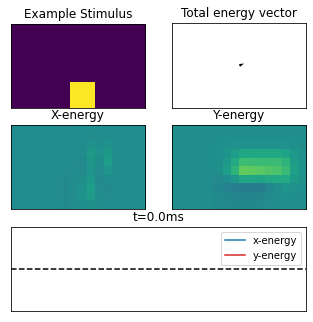

8.70061618245325e-17 4.9144036990952525e-18


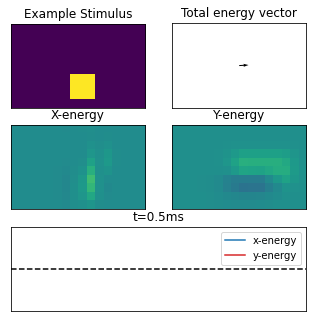

1.1358379146831553e-16 -4.384631512988528e-18


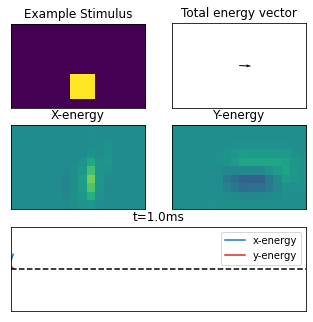

1.271443193733202e-16 -1.1624336918168475e-17


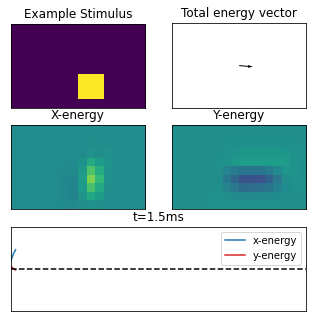

1.2712259104081986e-16 -1.5755700889896398e-17


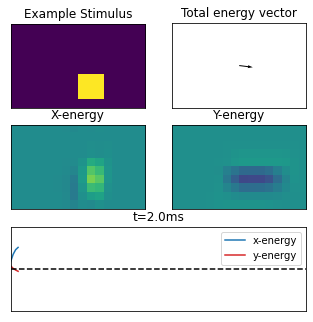

8.825675094555944e-17 -1.901250475494309e-17


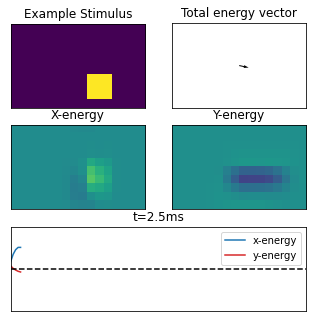

5.206481431051901e-17 -2.037568346157267e-17


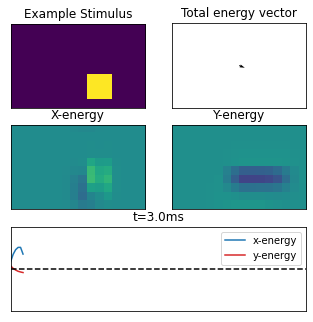

-2.2118504030255662e-17 -1.4732070350182786e-17


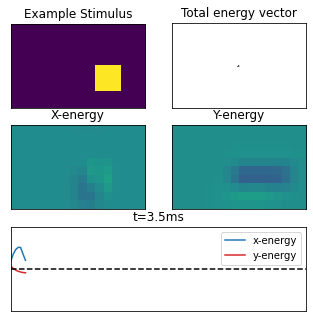

-7.70429580783342e-17 -9.476516731892902e-18


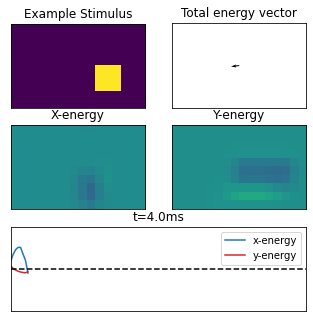

-1.1590843650013942e-16 -4.96157521601186e-18


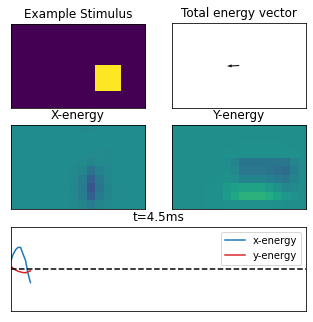

-1.3114210003698418e-16 5.171493292092982e-18


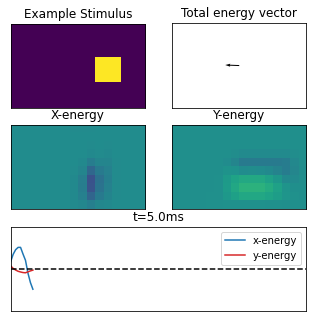

-1.39381851161479e-16 1.2858640319792972e-17


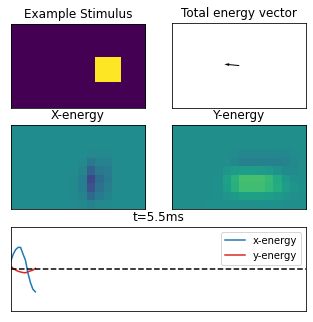

-1.42164961593426e-16 1.8453940209062884e-17


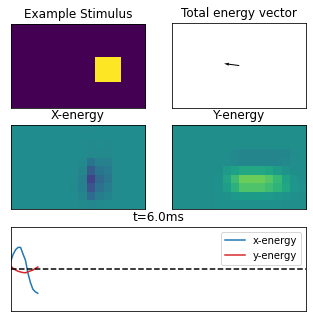

-1.4070144092288888e-16 2.2142619252324386e-17


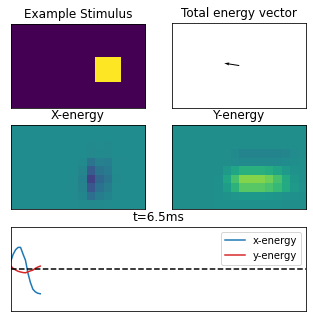

-1.3614351132880936e-16 2.4284546256204365e-17


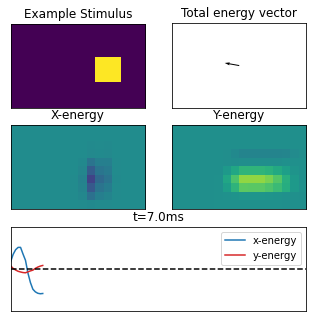

-1.2943358118515244e-16 2.5413929822934923e-17


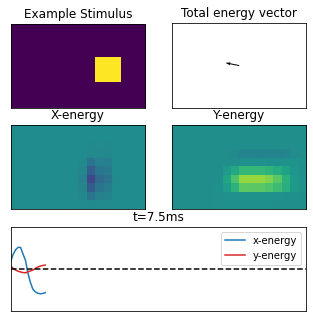

-1.119921371703931e-16 3.263220692478337e-17


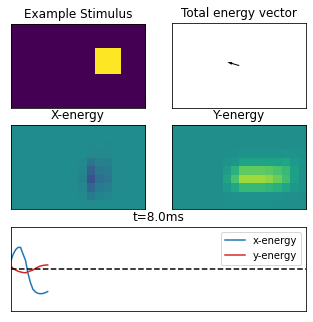

-9.748861779351984e-17 3.7954641447313084e-17


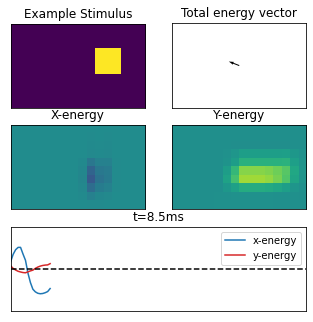

-8.526486841811004e-17 4.1363603578991886e-17


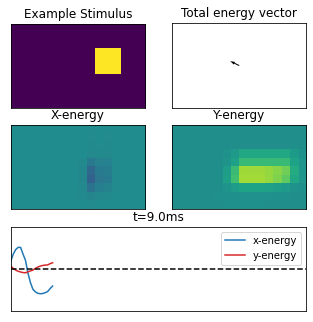

1.5334772612377943e-17 4.2860880218730443e-17


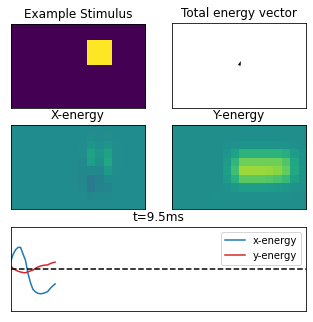

8.728952254451068e-17 4.396377785823146e-17


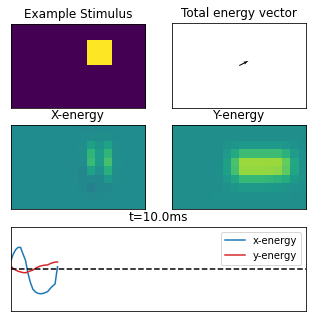

1.632806254079211e-16 4.291166715993671e-17


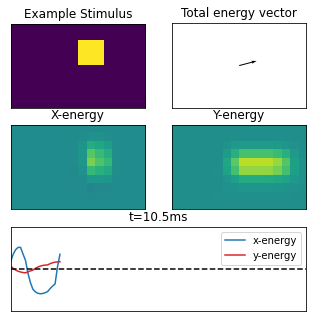

2.1651207328598234e-16 4.169241393866448e-17


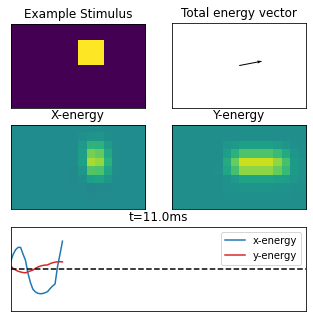

2.3096381605180147e-16 3.8213501426231065e-17


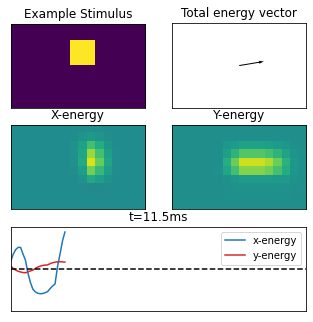

2.429224743468071e-16 3.518471931945105e-17


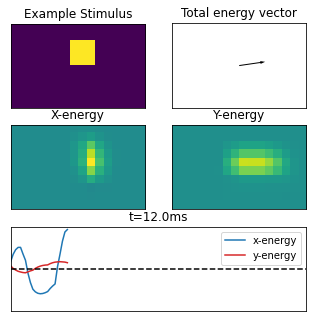

2.349556715264633e-16 3.606253032675834e-17


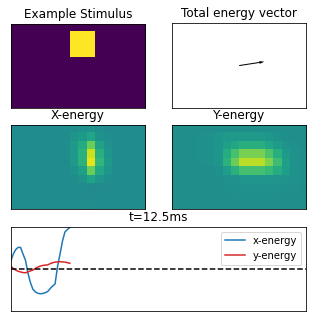

2.4200698506853235e-16 3.1754139168317153e-17


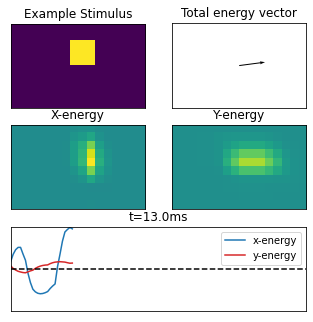

2.4279758188573927e-16 2.76897120478974e-17


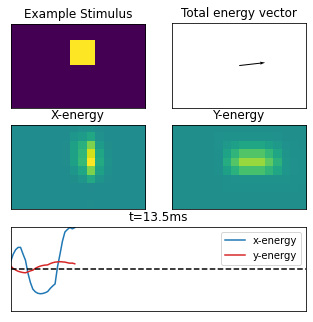

2.4367672274211773e-16 2.2766681681898746e-17


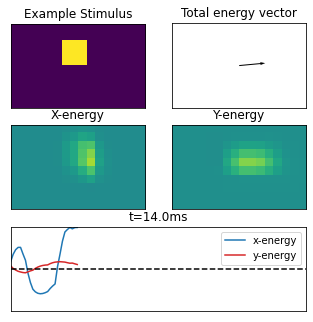

2.4812187449276785e-16 1.8661121776196826e-17


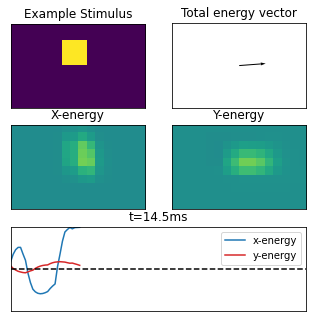

2.452858202429316e-16 1.444846762048267e-17


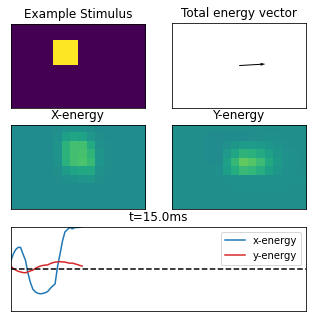

2.4798698167373344e-16 1.1163651646101948e-17


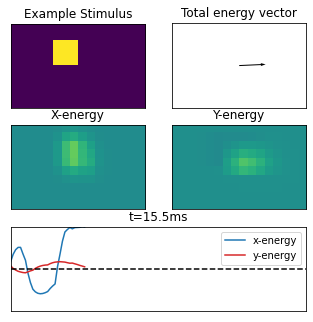

2.255171296090232e-16 -1.9253501840948204e-18


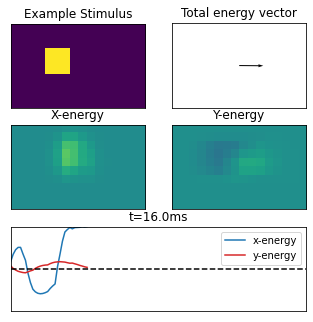

2.1444776842372604e-16 -1.163460516008434e-17


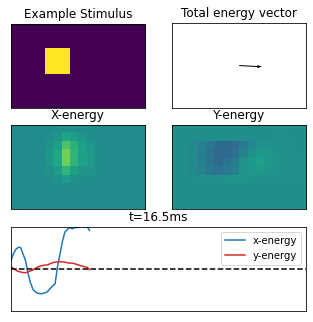

2.0839251271805707e-16 -1.854884391016192e-17


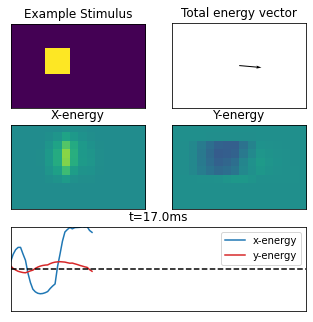

1.912397042817077e-16 -2.6488050623295536e-17


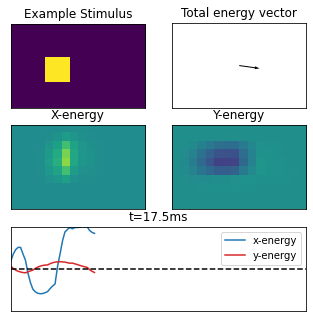

1.7781834024532926e-16 -3.231130313947049e-17


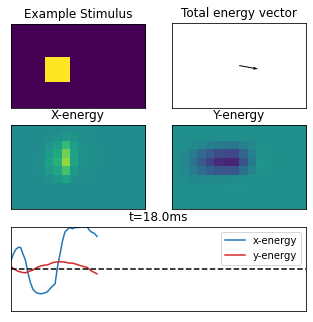

1.661451680784452e-16 -3.622453678370562e-17


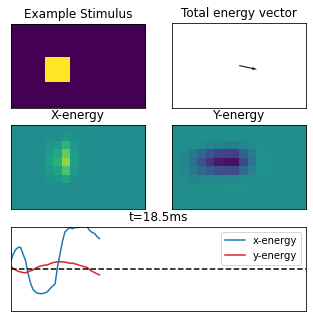

1.552939873405486e-16 -3.844836139635431e-17


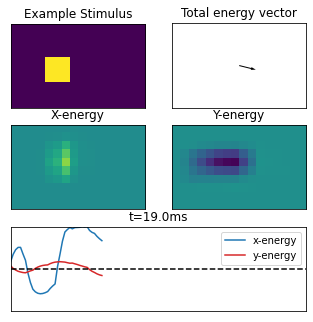

1.4470752343425373e-16 -3.927031316998256e-17


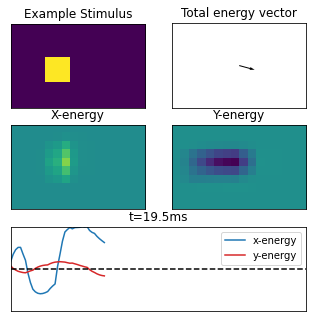

1.3420257461172968e-16 -3.903237557911047e-17


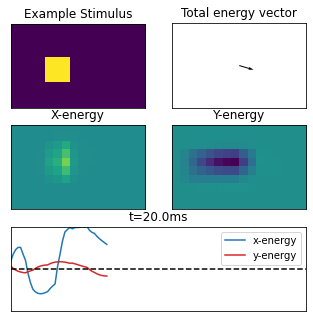

1.1308078986276018e-16 -4.1673238960064245e-17


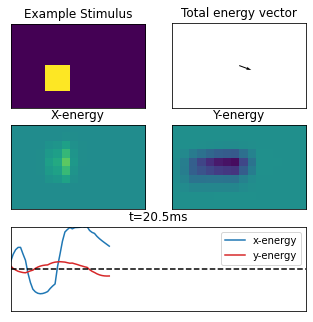

9.63789466700044e-17 -4.377626432955862e-17


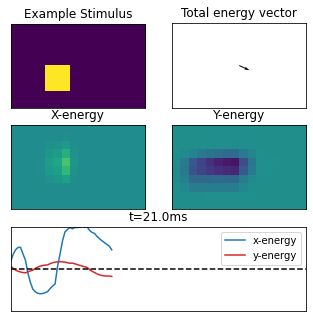

8.293044141697007e-17 -4.504863684485039e-17


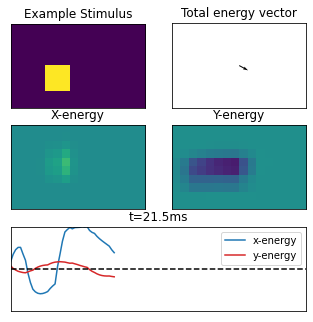

-2.902151470106746e-18 -4.364993667424113e-17


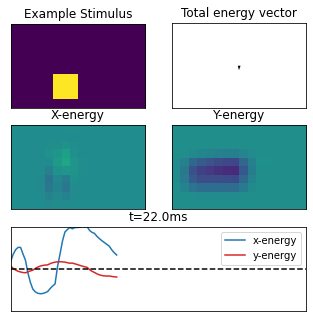

-6.708405915315353e-17 -4.31404423296281e-17


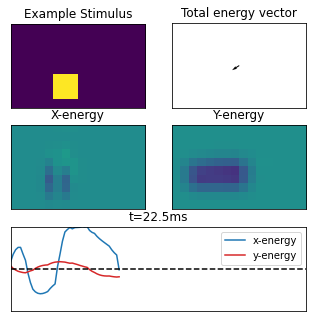

-1.3515984852194866e-16 -4.139217461951882e-17


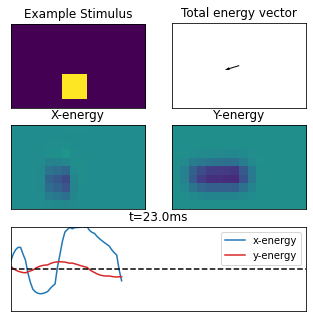

-1.8519607394808181e-16 -3.983865358274942e-17


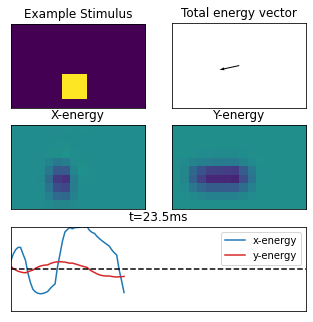

-2.0188952963815128e-16 -3.646719536957703e-17


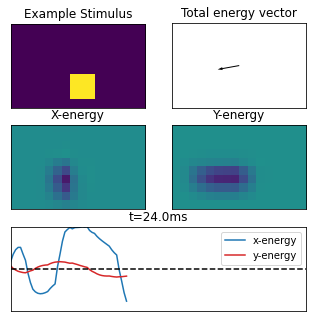

-2.1661005544938793e-16 -3.363185008463424e-17


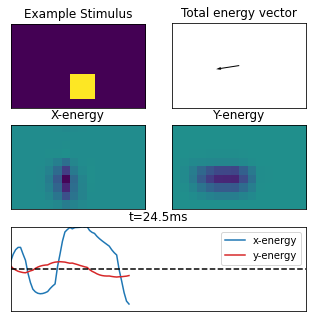

-2.1312576561657624e-16 -3.460594180280575e-17


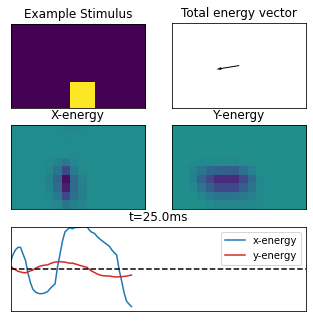

-2.226878248670043e-16 -3.051048796462414e-17


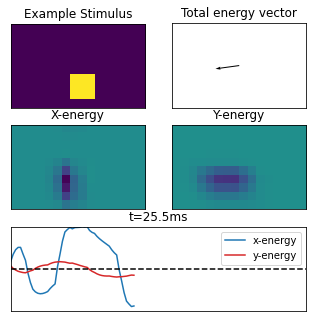

-2.258691760635872e-16 -2.6609025124399463e-17


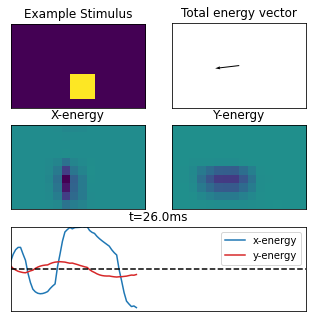

-2.31264049551147e-16 -2.190221794947856e-17


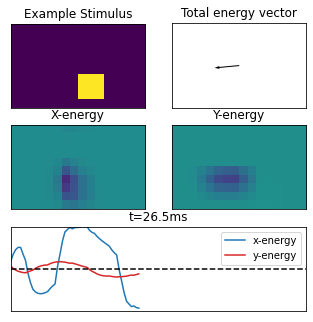

-2.388150857386459e-16 -1.795831570163095e-17


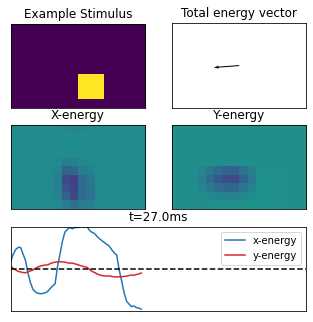

-2.392819685417375e-16 -1.3988675190215548e-17


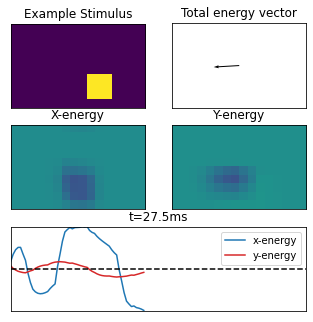

-2.441118564242292e-16 -1.0862551367543295e-17


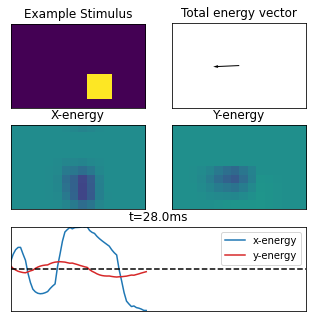

-2.237653059247669e-16 1.9669387957544046e-18


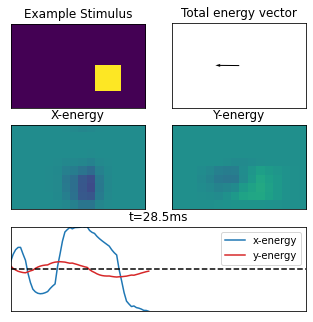

-2.1385904105167905e-16 1.1518483191345588e-17


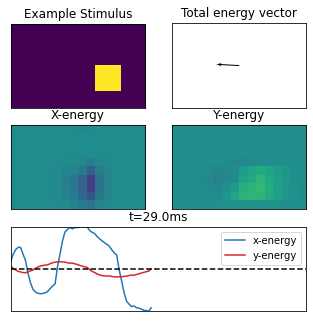

-2.0849199495195467e-16 1.8377305381867014e-17


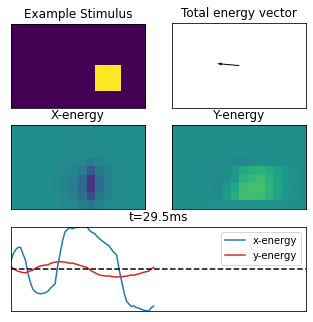

-1.9190688109562674e-16 2.6187715638680677e-17


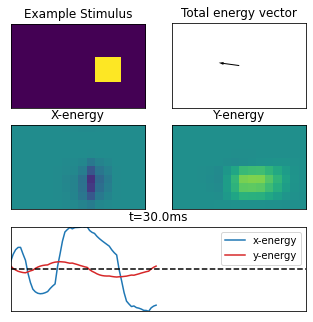

-1.786800416883972e-16 3.197755253794601e-17


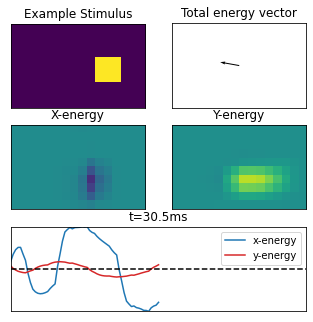

-1.6714455664952068e-16 3.588822843400049e-17


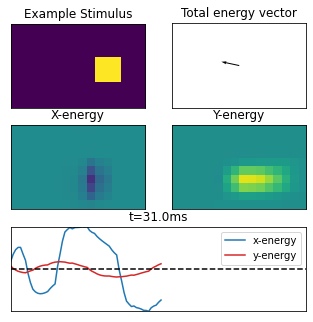

-1.5622743032150418e-16 3.813218323445108e-17


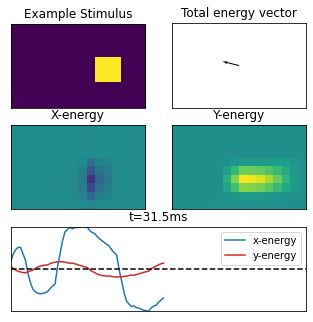

-1.4559053451571698e-16 3.8973113093526023e-17


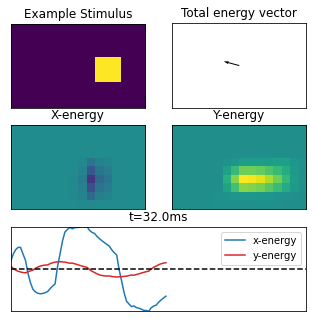

-1.3491253934798895e-16 3.880800190984468e-17


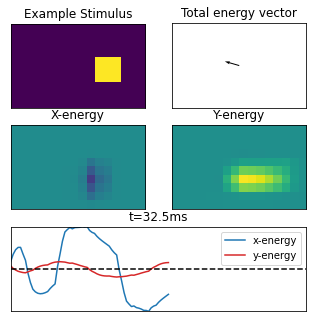

-1.1367074084260708e-16 4.1474872692087134e-17


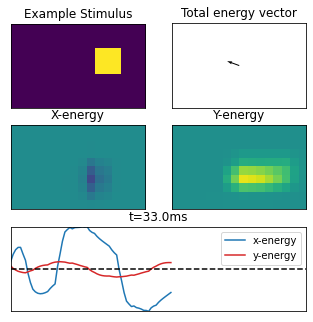

-9.690460537431166e-17 4.3575776983745893e-17


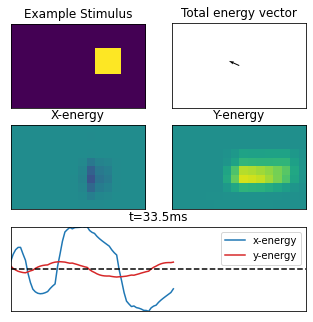

-8.327906914726407e-17 4.488320584509742e-17


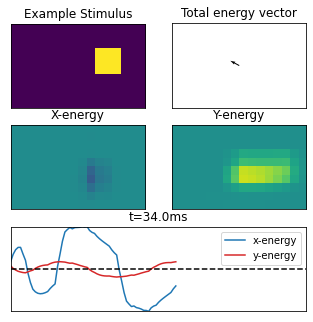

2.6867037428684746e-18 4.3574361180211955e-17


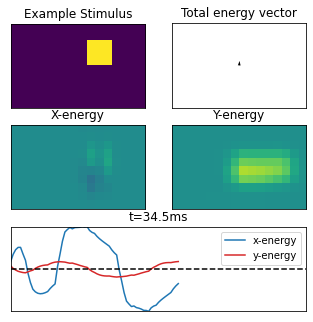

6.682300081788794e-17 4.3042920112550505e-17


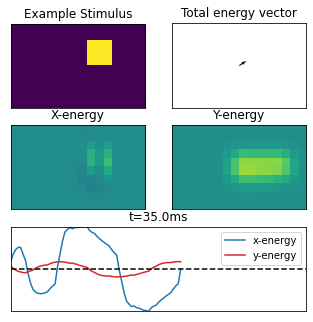

1.3494918259677721e-16 4.131082992407958e-17


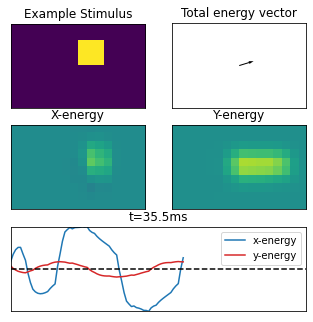

1.8504747698969136e-16 3.973208106938955e-17


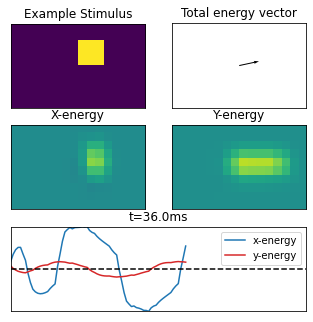

2.0184031692149116e-16 3.6380547055762305e-17


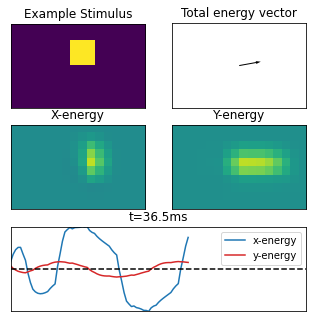

2.1659343032889468e-16 3.3557819729958215e-17


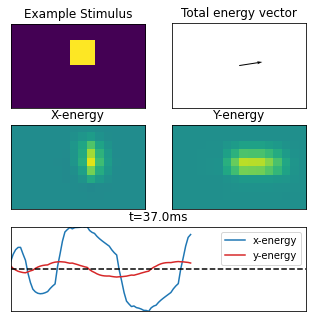

2.1310644789305276e-16 3.452507217455228e-17


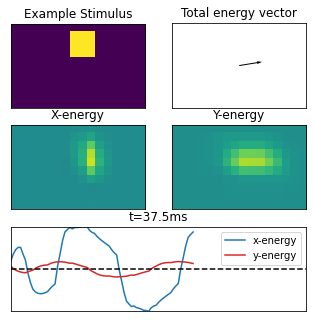

2.226431733827481e-16 3.040196345876628e-17


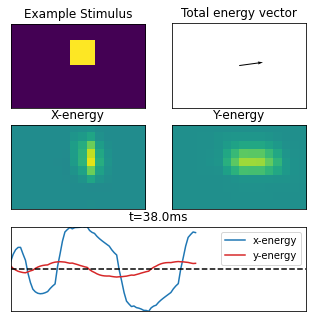

2.2590263745291043e-16 2.654808756504362e-17


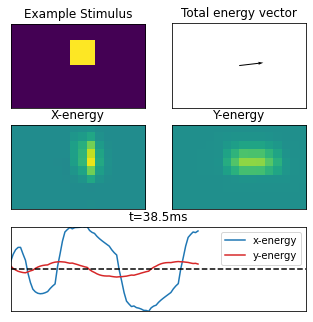

2.312036161432552e-16 2.1870953991973736e-17


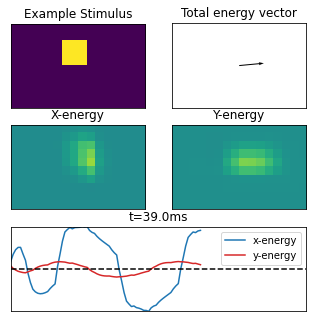

2.388270737891848e-16 1.7940022200522005e-17


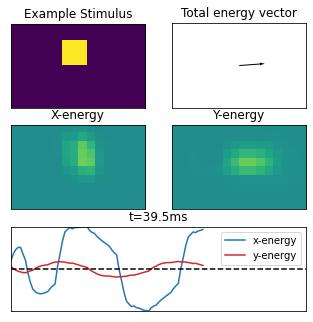

2.3924953034738967e-16 1.3938445926669634e-17


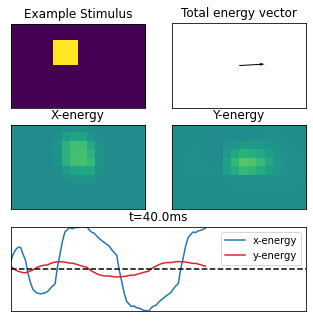

2.44106086692375e-16 1.0802258771038797e-17


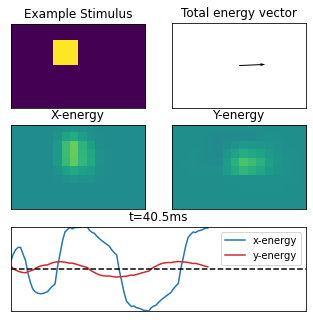

2.2371430530806444e-16 -1.9966543464536415e-18


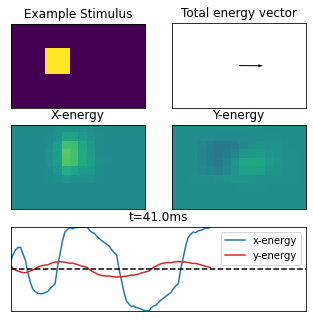

2.1386192711835214e-16 -1.1566925922449347e-17


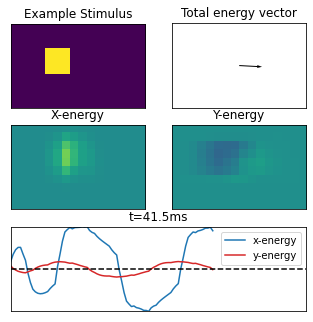

2.084914926504232e-16 -1.8404304058409688e-17


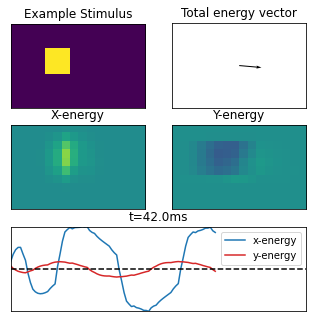

1.918592069329036e-16 -2.6237028172185494e-17


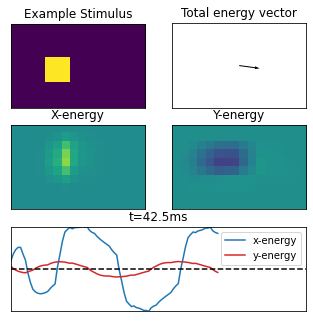

1.7866376291964542e-16 -3.203115797786446e-17


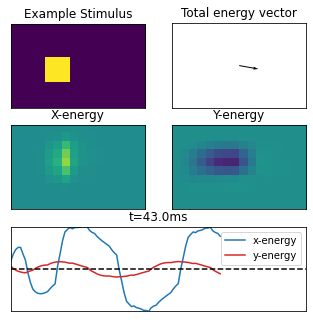

1.6703235385946514e-16 -3.593751855226536e-17


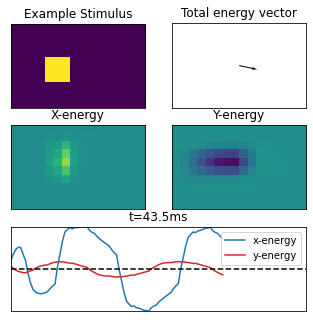

1.5613983247139333e-16 -3.820031656770275e-17


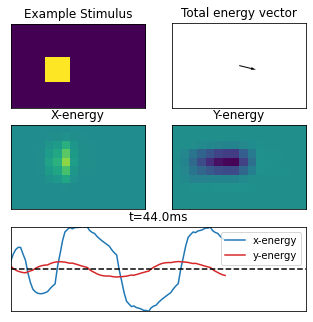

1.4547341833811107e-16 -3.9048170683045406e-17


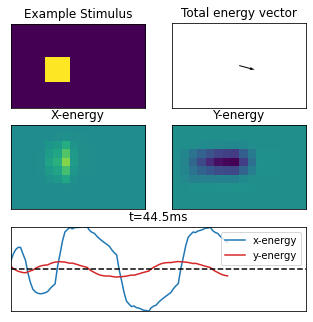

1.3486541701483782e-16 -3.8844319234264594e-17


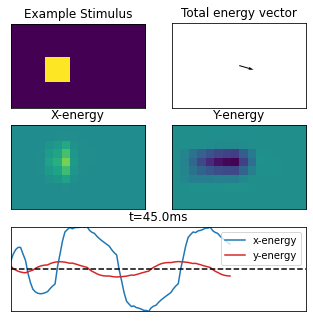

1.1367859410864783e-16 -4.1500312619629624e-17


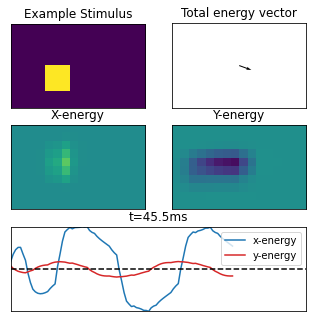

9.690646645777513e-17 -4.36524995371591e-17


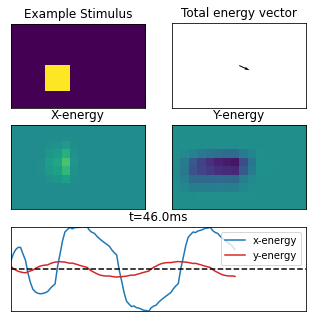

8.338903868042221e-17 -4.494402215015746e-17


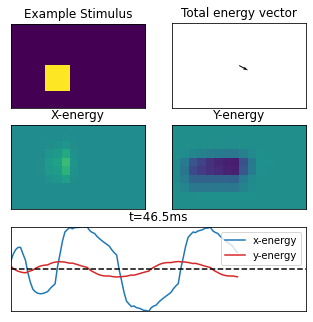

-2.555821584491287e-18 -4.359041890131031e-17


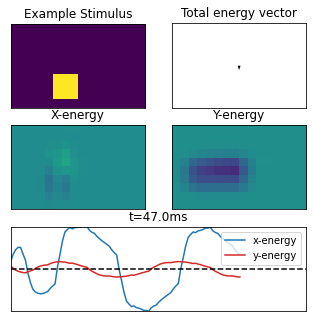

-6.682380180075946e-17 -4.3106502548285153e-17


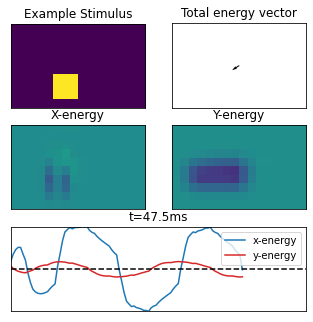

-1.3500354538169693e-16 -4.1368104558463794e-17


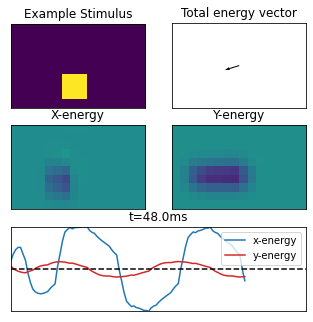

-1.8512008616911476e-16 -3.981625234729926e-17


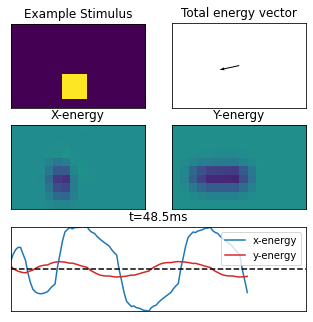

-2.0188098499648107e-16 -3.646959891282101e-17


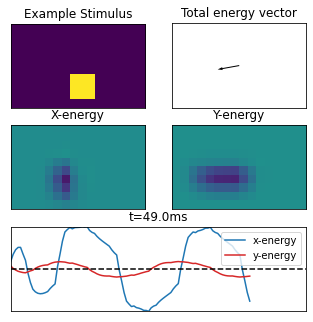

-2.1664056969686435e-16 -3.361605041286908e-17


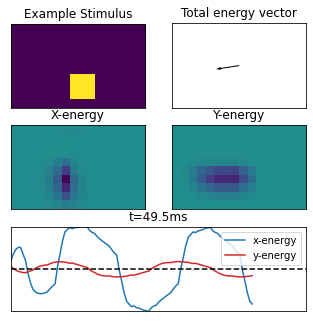

-2.1316243078367676e-16 -3.460180027396901e-17


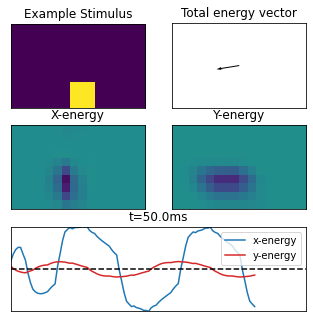

-2.227346073062968e-16 -3.0504731937069907e-17


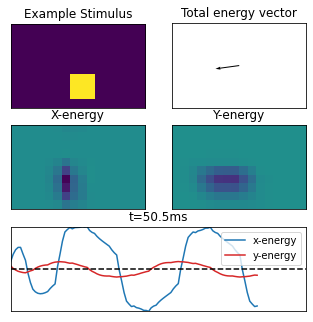

-2.2591636742167276e-16 -2.6604942901466708e-17


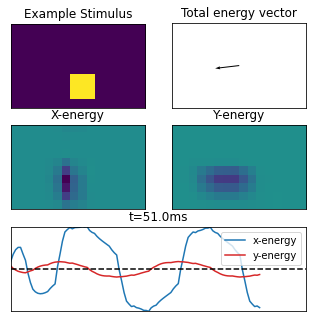

-2.3130036546772565e-16 -2.190351720187248e-17


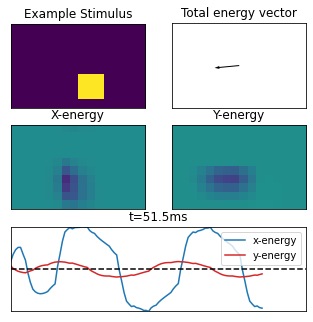

-2.388750388137171e-16 -1.7957669130647694e-17


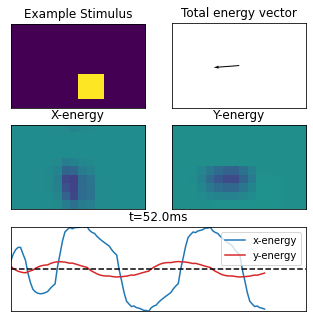

-2.3931964139645575e-16 -1.3983003674590148e-17


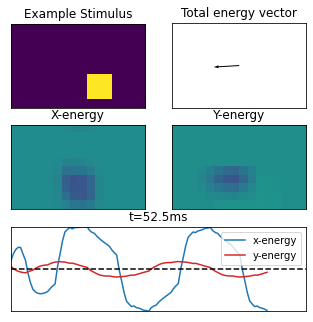

-2.4412356365758594e-16 -1.0852622477003399e-17


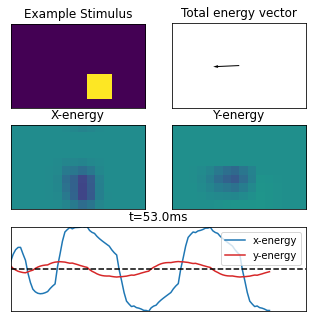

-2.237723163241091e-16 1.966262852683147e-18


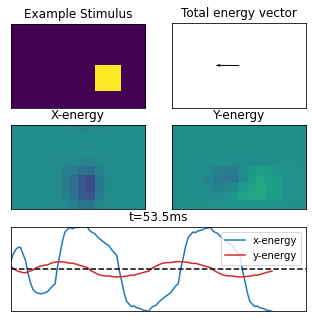

-2.1387386796203204e-16 1.1521138128371922e-17


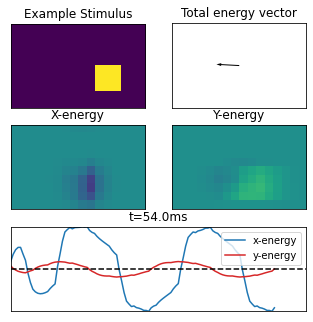

-2.0850683367505229e-16 1.8376761611992403e-17


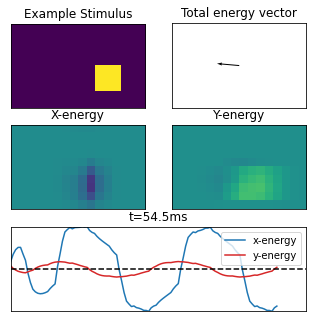

-1.9190362197373744e-16 2.6186824630360455e-17


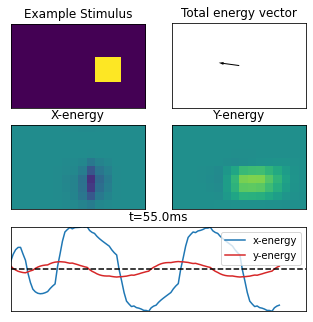

-1.7868364091368521e-16 3.198785550687478e-17


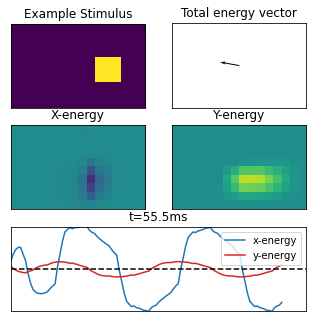

-1.6714402025054334e-16 3.589300834035669e-17


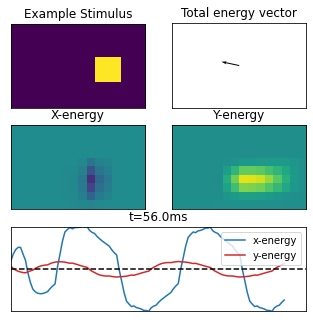

-1.562302943991301e-16 3.813785392146824e-17


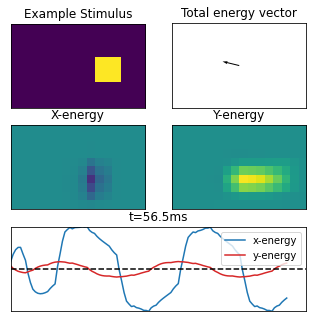

-1.455624695377733e-16 3.896775719038622e-17


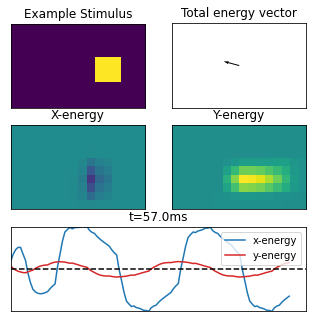

-1.348873352717168e-16 3.878550726789285e-17


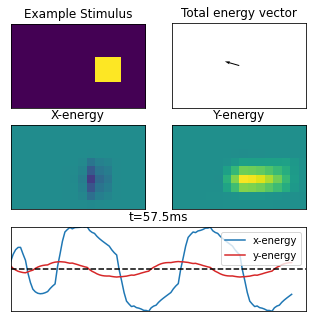

-1.1367272747211045e-16 4.14681670699808e-17


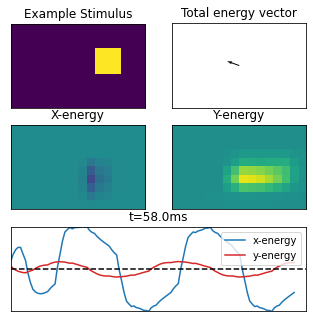

-9.690225108807074e-17 4.357879836554412e-17


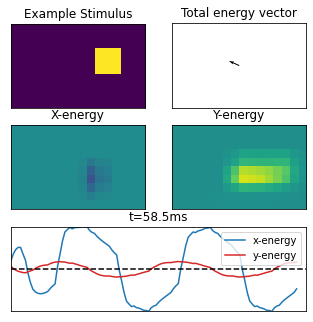

-8.328985583513336e-17 4.488059048153954e-17


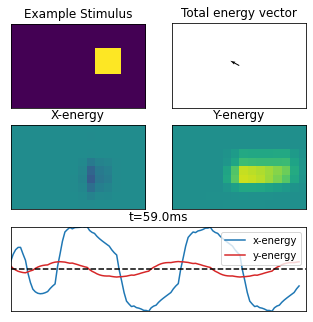

2.6720833007669424e-18 4.356746459175578e-17


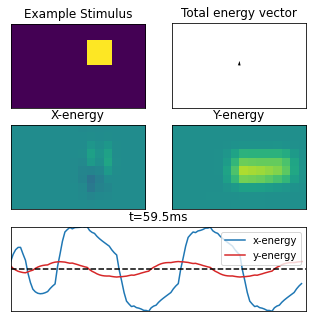

In [12]:
combined_img_files = []
process_combined = True
step_size = 1
x_energy_min = np.min(motion_contrast_x)
x_energy_max = np.max(motion_contrast_x)
y_energy_min = np.min(motion_contrast_y)
y_energy_max = np.max(motion_contrast_y)
matplotlib.rc ('figure', figsize= (5.3, 5.3))

for i in range(0, stim.shape[0], step_size):
        
    fig = plt.figure()
    gs = GridSpec(3, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[2,:])
    dir_ax = fig.add_subplot(gs[0,1])
    ax_y_energy = fig.add_subplot(gs[1,1])
    
    ax0.imshow(np.transpose(stim)[:,:,i])
    ax0.set_title("Example Stimulus")
    ax0.set_yticks([])
    ax0.set_xticks([])
    ax1.imshow(np.transpose(motion_contrast_x)[:,:,i],
               vmin=x_energy_min,
               vmax=x_energy_max)
    ax1.set_title("X-energy")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax_y_energy.imshow(np.transpose(motion_contrast_y)[:,:,i],
                       vmin=y_energy_min,
                       vmax=y_energy_max)
    ax_y_energy.set_title("Y-energy")
    ax_y_energy.set_yticks([])
    ax_y_energy.set_xticks([])
    
    ax2.plot(motion_contrast_per_frame_x[:i], color='tab:blue', label="x-energy")
    ax2.plot(motion_contrast_per_frame_y[:i], color='tab:red', label="y-energy")
    ax2.axhline(y=0.0, color='black', linestyle='--')
    ax2.set_xlim([0, motion_contrast_per_frame_x.shape[0]])
    y_max = max(np.max(motion_contrast_per_frame_x), np.max(motion_contrast_per_frame_y))
    y_min = min(np.min(motion_contrast_per_frame_x), np.min(motion_contrast_per_frame_y))
    ax2.set_ylim([y_min, y_max])
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title("t="+str(i/2)+"ms")
    ax2.legend(loc='upper right')
    
    dir_ax.set_title("Total energy vector")
    dir_ax.set_yticks([])
    dir_ax.set_xticks([])
    x_max = max(-np.min(motion_contrast_per_frame_x), 
                np.max(motion_contrast_per_frame_x))
    y_max = max(-np.min(motion_contrast_per_frame_y), 
                np.max(motion_contrast_per_frame_y))
    norm = np.sqrt(x_max * x_max + y_max * y_max)
    dir_ax.set_xlim([-0.2, 0.2])
    dir_ax.set_ylim([-0.2, 0.2])
    dir_ax.quiver(0, 0,
                  motion_contrast_per_frame_x[i] / norm, 
                  motion_contrast_per_frame_y[i] / norm,
                  scale = 5)
    print(motion_contrast_per_frame_x[i], 
          motion_contrast_per_frame_y[i])
    
    combined_filename = "comb" + str(i/2) + ".png"
    plt.savefig(combined_filename)
    combined_img_files.append(imageio.imread(combined_filename))
    plt.show()

if process_combined:
    imageio.mimsave('comb_movie.gif', combined_img_files)
